# Задание к лекции 9

Скачать файл user_actions.csv. Файл содержит логи о действиях пользователей, причём одному действию должны соответствовать два лога - START (отправлен запрос) и ЕND (получен ответ). Используя Jupyter notebook, вывести следующие данные:
0. Данные, которые не могут быть обработаны
1. Процентное соотношение операций (круговая диаграмма)
2. Общее количество операций по неделям
3. Для операций поиска - топ-10 наиболее длительных операций с указанием затраченного времени
4. Для остальных операций:
а) Гистограмма входных данных по каждой операции 
б) Диаграмма результатов - отобразить на графике количество успешных, условно успешных (warning) и неуспешных результатов.
в) Зависимость затраченного времени от количества входных данных (диаграмма рассеяния) 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('user_actions.csv')
data.describe()

,actionId,currentUser,createdDateTime,message
count,18995,18995,18995,18995
unique,9965,15,18786,13400
top,8997fb06-1b54-4954-9929-59a965f63341,lxusdzwncy,2019-09-02 10:53:00,[END] [SEARCH]: [num_results=9]
freq,2,1352,3,18


In [3]:
data.head()

,actionId,currentUser,createdDateTime,message
0,875ee856-7376-4d2b-bdb3-159696551ea9,tpoyqv,2019-10-03 14:12:23,"[END] [IMPORT]: [num_success=2, num_failed=1, ..."
1,7c592432-a361-41e9-9e1d-3b7097e74447,okiuvpr,2019-10-23 10:10:00,[START] [SEARCH]: [approved_by=renwhscyxdi]
2,9f2287f6-425a-4d5a-9381-bec13285e2fc,hojgrxwbinkfcp,2019-06-03 14:36:00,[START] [IMPORT]: [num_records=497]
3,b830e027-5f2b-41fc-bd19-9580e0f25cea,lxusdzwncy,2019-04-03 12:57:10,"[END] [APPROVE]: [num_success=2, num_failed=49..."
4,f4d9f09f-f83c-41a4-9abd-fd5c66bf1bfb,okiuvpr,2019-02-10 15:07:40,"[END] [IMPORT]: [num_success=41, num_failed=8,..."


In [4]:
data['createdDateTime'] = pd.to_datetime(data['createdDateTime'])

In [5]:
data.isna().sum()

actionId           0
currentUser        0
createdDateTime    0
message            0
dtype: int64

There's no missing values.

In [6]:
data['status'] = data['message'].apply(lambda m: m.split(']')[0][1:])
data['operation_type'] = data['message'].apply(lambda m: m.split(']')[1][2:])
data['operation_message'] = data['message'].apply(lambda m: m.split(']')[2][3:])
data.pop('message')
data.head()

,actionId,currentUser,createdDateTime,status,operation_type,operation_message
0,875ee856-7376-4d2b-bdb3-159696551ea9,tpoyqv,2019-10-03 14:12:23,END,IMPORT,"num_success=2, num_failed=1, num_warning=136"
1,7c592432-a361-41e9-9e1d-3b7097e74447,okiuvpr,2019-10-23 10:10:00,START,SEARCH,approved_by=renwhscyxdi
2,9f2287f6-425a-4d5a-9381-bec13285e2fc,hojgrxwbinkfcp,2019-06-03 14:36:00,START,IMPORT,num_records=497
3,b830e027-5f2b-41fc-bd19-9580e0f25cea,lxusdzwncy,2019-04-03 12:57:10,END,APPROVE,"num_success=2, num_failed=495, num_warning=15"
4,f4d9f09f-f83c-41a4-9abd-fd5c66bf1bfb,okiuvpr,2019-02-10 15:07:40,END,IMPORT,"num_success=41, num_failed=8, num_warning=15"


In [7]:
data.describe()

,actionId,currentUser,createdDateTime,status,operation_type,operation_message
count,18995,18995,18995,18995,18995,18995
unique,9965,15,18786,2,6,11166
top,8997fb06-1b54-4954-9929-59a965f63341,lxusdzwncy,2019-09-02 10:53:00,START,IMPORT,num_results=8
freq,2,1352,3,9504,6806,18
first,NaN,NaN,2019-01-01 08:03:00,NaN,NaN,NaN
last,NaN,NaN,2019-12-31 16:39:15,NaN,NaN,NaN


## Pie plot

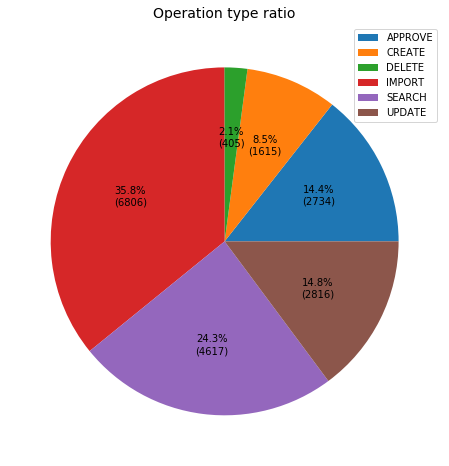

In [8]:
plt.figure(figsize=(12, 8))
labels = data.groupby(['operation_type']).count()['status'].index
values = data.groupby(['operation_type']).count()['status'].values

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)

plt.pie(values, autopct=lambda pct: func(pct, values))
plt.legend(labels)
plt.title('Operation type ratio', fontsize=14);

## Operations per week

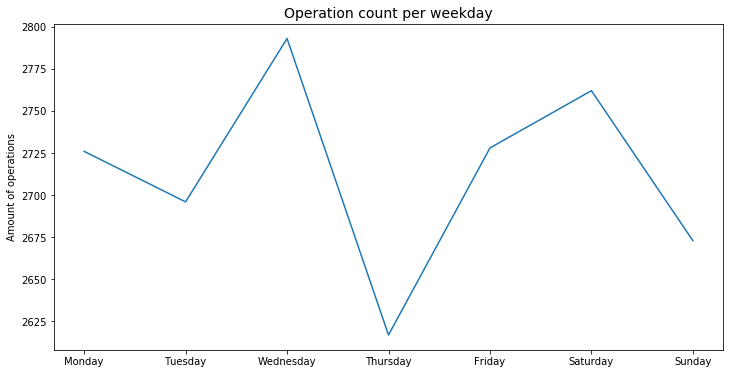

In [9]:
plt.figure(figsize=(12,6))
df = data
df.index = df.createdDateTime
days = ['Monday', "Tuesday", 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df.groupby(df.index.weekday_name).count()['operation_type'].reindex(days)
plt.plot(df.groupby(df.index.weekday_name).count()['operation_type'].reindex(days))
plt.ylabel('Amount of operations')
plt.title('Operation count per weekday',fontsize=14);

In [10]:
def lamb(x):
    if len(x) != 2:
        return None
    else:
        return np.abs(x[0] - x[1]).total_seconds()

times = data.groupby(['actionId'])[['createdDateTime']].agg(lamb)
time_dict = dict(zip(times.index, times.values))

df = data.copy
data['duration'] = data['actionId'].map(time_dict).apply(lambda x: x[0])
data = data.dropna()

## Top 10 longest seraches

In [11]:
sorted_data = data.sort_values(by=['duration'], ascending=False)
sorted_search_data = sorted_data.loc[sorted_data['operation_type'] == 'SEARCH']
sorted_search_data[['createdDateTime', 'duration']][:10]

,createdDateTime,duration
createdDateTime,,
2019-04-01 13:58:23,2019-04-01 13:58:23,983.0
2019-04-01 13:42:00,2019-04-01 13:42:00,983.0
2019-11-29 15:13:00,2019-11-29 15:13:00,980.0
2019-11-29 15:29:20,2019-11-29 15:29:20,980.0
2019-06-02 11:12:19,2019-06-02 11:12:19,979.0
2019-06-02 10:56:00,2019-06-02 10:56:00,979.0
2019-01-17 12:49:00,2019-01-17 12:49:00,976.0
2019-01-17 13:05:16,2019-01-17 13:05:16,976.0
2019-04-12 12:08:55,2019-04-12 12:08:55,955.0


In [12]:
start_data = data.loc[data['status'] == 'START'] #.iloc[data['operation_type'] != 'SEARCH'] # ['operation_message']
start_data_no_search = start_data.loc[start_data['operation_type'] != 'SEARCH']
start_data_no_search['num_records'] = start_data_no_search['operation_message'].apply(lambda s: int(s.split('=')[1]))

## Hist of num records for each type

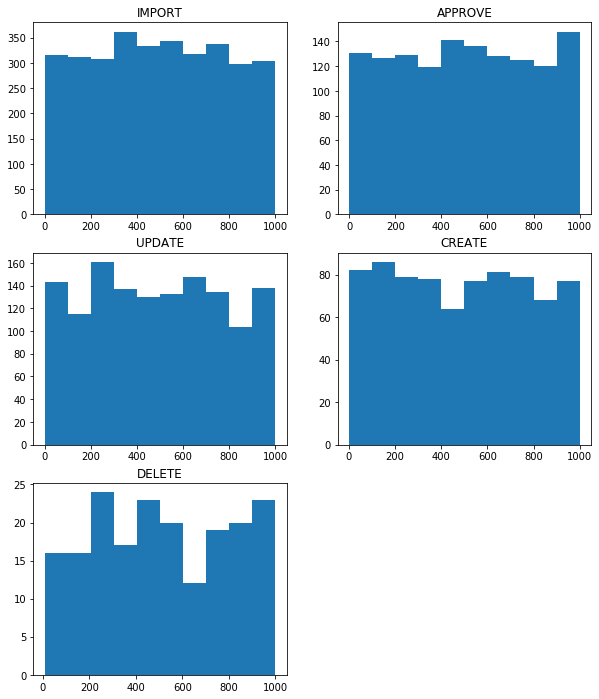

In [13]:
plt.figure(figsize=(10, 12))
counter_subplot = 1
for operation_type in start_data_no_search['operation_type'].unique():
    plt.subplot(3, 2, counter_subplot)
    counter_subplot += 1
    to_show = start_data_no_search.loc[start_data_no_search['operation_type'] == operation_type] 
    plt.hist(to_show['num_records'])
    plt.title(operation_type)

In [14]:
def get_num(index=0):
    def func(s):
        raw = s.split(',')[index]
        return int(raw.split('=')[1])
    return func
        
end_data = data.loc[data['status'] == 'END']
end_data_no_search = end_data.loc[end_data['operation_type'] != 'SEARCH']

end_data_no_search['num_success'] = end_data_no_search['operation_message'].apply(get_num(0))
end_data_no_search['num_failed'] = end_data_no_search['operation_message'].apply(get_num(1))
end_data_no_search['num_warning'] = end_data_no_search['operation_message'].apply(get_num(2))

## Barplot for succes, failes and warning results

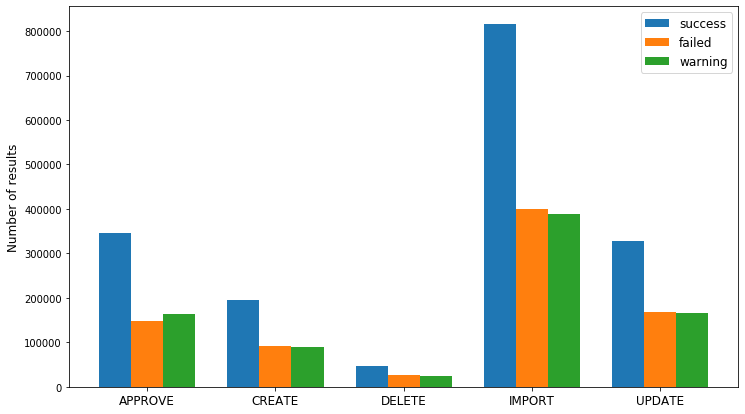

In [15]:
plt.figure(figsize = (12,7))
bars1 = end_data_no_search.groupby(['operation_type'])['num_success'].sum()
bars2 = end_data_no_search.groupby(['operation_type'])['num_failed'].sum()
bars3 = end_data_no_search.groupby(['operation_type'])['num_warning'].sum()

barWidth = 0.25

r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

plt.bar(r1, bars1, width=barWidth, label='success')
plt.bar(r2, bars2, width=barWidth, label='failed')
plt.bar(r3, bars3, width=barWidth, label='warning')

plt.xticks([r + barWidth for r in range(len(bars1))], bars1.index, fontsize=12)
plt.ylabel('Number of results', fontsize=12)
 
plt.legend(fontsize=12)
plt.show()

## Duration dependence on the number of operations

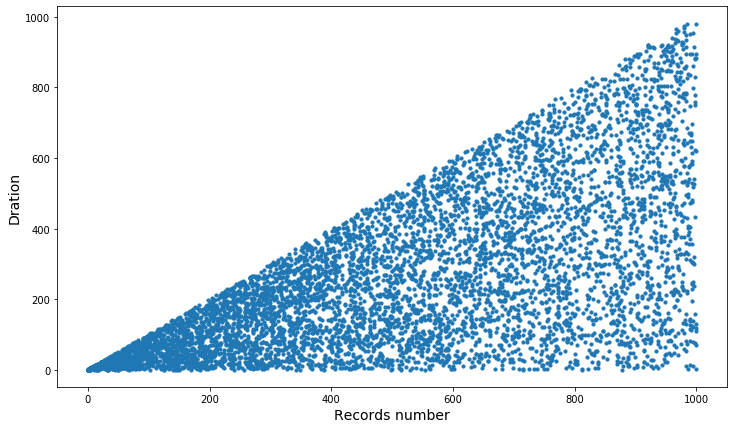

In [16]:
plt.figure(figsize=(12,7))
x = start_data_no_search['num_records']
y = start_data_no_search['duration']
plt.scatter(x, y, s = 10)
plt.xlabel('Records number', fontsize=14)
plt.ylabel('Dration', fontsize=14);